In [1]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from itertools import product
from IPython.display import clear_output
from scipy.signal import convolve2d

plt.rcParams["figure.figsize"] = (20,8)

In [2]:
import text_flappy_bird_gym

We set a seed for our experiments.

In [3]:
np.random.seed(0)

**Important :** 

Since the game has no specific end policy (unless the agent dies), it becomes computationally expensive to train the agent for longer and to test it since it can potentially reach infinite scores. On the test runs, after 2000 training episodes, the agent was able to reach scores of 100'000 on average. Therefore, we will set a maximum target score.

According to <a href="https://www.speedrun.com/flappybird/full_game?h=Highscore-Original_Game&x=jdr1ol52-onvm0mnm.9qj25wo1">the Speed Run website</a>, the highest score ever at Flappy Bird (or one of its emulators) is 2311. Therefore, we will set the **target high score to 2000**.

# Environment

The following code displays the text environment.

As a trial code, at every step, the agent chooses a random action. Hence, you'll see that the performance of this code is terrible.

In [4]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(.1) # FPS
    
    clear_output(wait=True)
    
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[      |         |   ]
[      |         |   ]
[      |             ]
[      |             ]
[     *|             ]
[                    ]
[                |   ]
[                |   ]
[                |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=-3)


## Method 1 : Q-learning: Off-policy TD Control

This implementation is based on the eponymous section 6.5 from __Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.__

First, we need to determine the possible states.

In this environment, we will consider the states as the tuples (x, y) where x and y are respectively the longitudinal and vertical distances to the center of the closest upcoming pipe gap.

Given the setup of the environment :
- x can take integer values from 0 to width (=20)
- y can take integer values from -height (=-15) to height (=15)

In [5]:
class Q_learning_flappy_bird():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        self.max_score = 2000
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        
        self.Q = np.random.rand(n_x_states, n_y_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :] = 0
        
        self.train_iteration = -1
        
        self.score_history = []
        self.death_causes = []
        self.reward_history = []
        
        self.accuracy_history = []
        
        self.death_cause_play = None
        self.score_play = None
        self.reward_play = None
    
    
    def _distance_to_state(self, x, y):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        return state_x, state_y
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind
    
    def _step_size(self, alpha, i, i_lim=1000):
        """
        Defines the step size choosing policy to assure convergence.
        """
        if (i > i_lim):
            return alpha / ((i - i_lim) ** 1)
        else:
            return alpha
    
    
    def _epsilon_decay(self, epsilon, i, i_lim=1000):
        if i <= i_lim:
            return epsilon
        return epsilon / ((i - i_lim) ** 1)
    
    
    def _epsilon_greedy(self, epsilon, x, y):
        """
        Defines the epsilon-greedy policy of training.
        """
        random_number = np.random.random()
        if random_number < epsilon:
            action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
        else:
            action = self._argmax(self.Q[x, y, :])
        
        return action
    
    def _render_game(self, i, top_score, sleep_time):
        """
        Renders the game with a certain sleep time (1/FPS)
        """
        os.system("clear")
        
        if i:
            print(f"Episode : {i+1}/{n_episodes}")
            
        print("Top score :", top_score)
        
        sys.stdout.write(self.env.render())
        
        if sleep_time:
            time.sleep(sleep_time) # FPS

        clear_output(wait=True)
    
    
    def _evaluate_distance_to_benchmark(self, Q_benchmark):
        """
        This function calculates the accuracy between the Q of the current agent and a certain Q_Benchmark.
        """
        benchmark_policy = np.argmax(Q_benchmark, axis=-1)
        current_policy = np.argmax(self.Q, axis=-1)
        
        accuracy = np.sum(benchmark_policy == current_policy)
        accuracy = accuracy / benchmark_policy.size
        
        return accuracy
    

    
    def train(self, n_episodes, alpha, epsilon, gamma, i_lim=1000, Q_benchmark=None, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            self.train_iteration += 1
            
            obs = self.env.reset()
            x, y = obs[0]
            x, y = self._distance_to_state(x, y)
            
            cumulative_reward = 0
            
            while True:
                # Select next action
                decayed_epsilon = self._epsilon_decay(epsilon, self.train_iteration, i_lim=i_lim)
                action = self._epsilon_greedy(epsilon, x, y)

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    else:
                        self.death_causes.append("Floor")
                
                # If we reach the Max Score
                if score == self.max_score:
                    done = True
                    self.death_causes.append("Max score")
                        
                # If we manage to go through a gap, we get a reward of 10
                elif x==0 and not done:
                    reward = 1
                
                cumulative_reward += reward
                
                # Update the Q according to the Q-learning update equation
                step_size = self._step_size(alpha, self.train_iteration, i_lim=i_lim)
                self.Q[x, y, action] += step_size * (reward + gamma * np.max(self.Q[x_, y_, :]) - self.Q[x, y, action])
                
                # Update x and y
                x, y = x_, y_
                
                # Calculate accuracy with respect to benchmark
                if Q_benchmark is not None:
                    self.accuracy_history.append(self._evaluate_distance_to_benchmark(Q_benchmark))
                
                # Render the game
                if show_episodes:
                    self._render_game(i, top_score, 0)

                # If player is dead break
                if done:
                    self.Q[x, y, action] += step_size * (reward - self.Q[x, y, action])
                    break
            
            self.score_history.append(score)
            self.reward_history.append(cumulative_reward)

        self.env.close()
        
        return self
    
    
    def plot_training_rewards(self):
        plt.plot(self.reward_history)
        plt.xlabel("Training episodes")
        plt.ylabel("Rewards")
        
        plt.show()
    
    
    def play(self, display=True, sleep_time=0.1):
        obs = self.env.reset()
        x, y = obs[0]
        x, y = self._distance_to_state(x, y)
        self.reward_play = 0
        
        top_score = float("-inf")

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            
            score = info['score']
            if score > top_score:
                top_score = score

            
            if not done and x == 0:
                reward = 10
            elif done:
                reward = -100
            self.reward_play += reward
            
            if done and (score != self.max_score):
                if x == 0:
                    self.death_cause_play = "Collision"
                else:
                    self.death_cause_play = "Floor"
            
            
            #print(self.score_play)
            # Render the game
            if display:
                self._render_game(None, top_score, sleep_time)
            
            # Early breaking if the agent performs well and doesn't stop
            if score == self.max_score:
                done = True
                self.death_cause_play = "Max Score"

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        self.env.close()
        
        return self

To test our test, we first need initialize an environment and an agent.

In [6]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning = Q_learning_flappy_bird(env=env, 
                                     width = width, 
                                     height = height, 
                                     pipe_gap = pipe_gap)

#### Example of training

We then train our agent for 100 episodes with certain parameters.

In [7]:
n_episodes = 100
alpha = 0.1
epsilon = 0.1
gamma = 0.9

train_model = q_learning.train(n_episodes=n_episodes,
                              alpha=alpha,
                              gamma=gamma,
                              epsilon=epsilon)

Episode : 100/100
Top score : 11
Text Flappy Bird!
Score: 1
----------------------
[      |         |   ]
[      |         |   ]
[      |             ]
[                    ]
[                    ]
[                    ]
[                |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[     *|         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=9)


## Do the rewards converge ?

In [8]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

We train 100 agents for 5000 episodes and examine the evolution of their training rewards (keep in mind that these are impacted by the $\epsilon$-greedy policy).

In [9]:
alpha = 0.1
epsilon = .1
gamma = .9

train_episodes = 5000
n_agents = 100

rewards_array = []



for i in tqdm(range(n_agents)):
    q_learning = Q_learning_flappy_bird(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)
    
    q_learning = q_learning.train(n_episodes=train_episodes,
                                  alpha=alpha,
                                  epsilon=epsilon,
                                  gamma=gamma,
                                  show_episodes=False)
    
    rewards_array.append(q_learning.reward_history)

100%|██████████████████████████████████████████████████████████████| 100/100 [09:22<00:00,  5.62s/it]


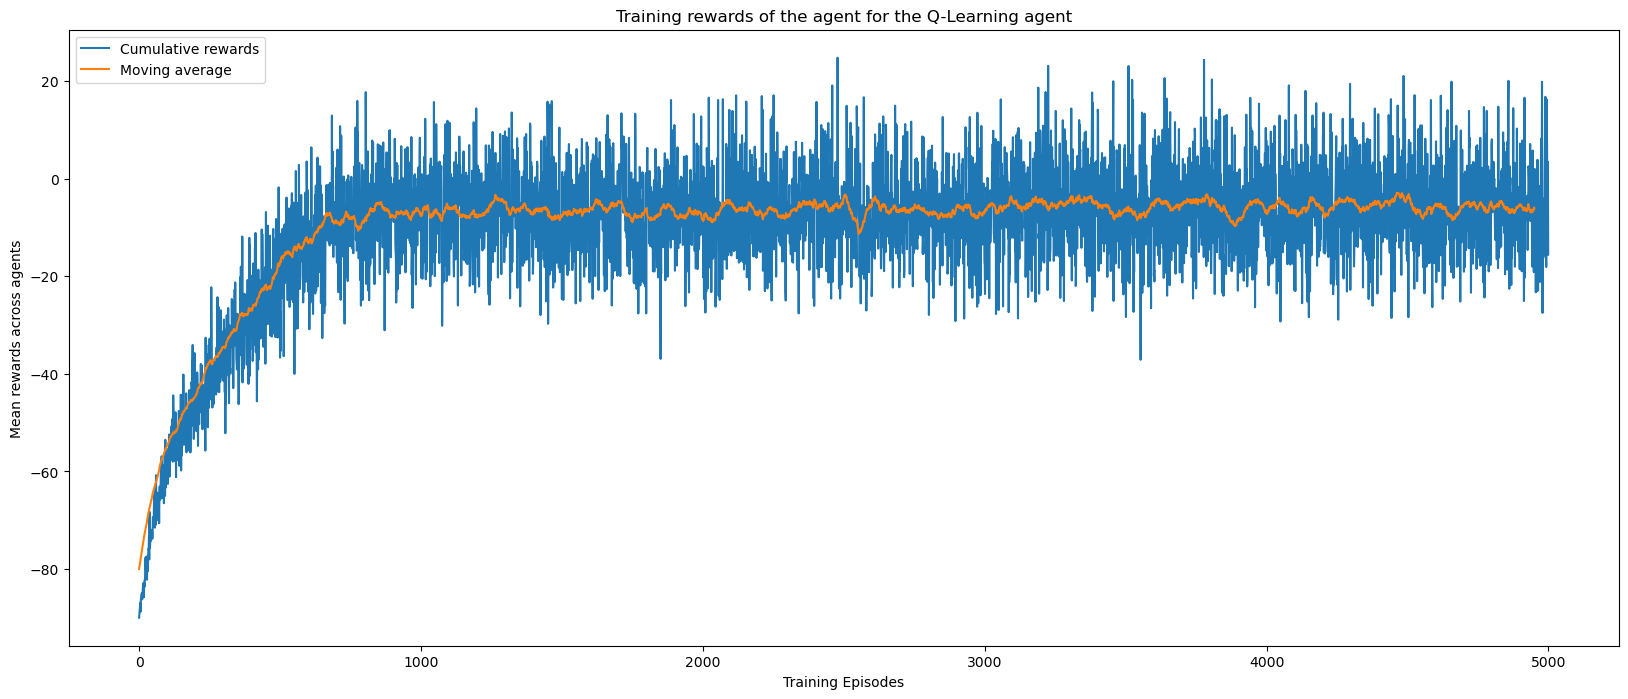

In [10]:
rewards_array = np.array(rewards_array)
mean_rewards_per_step = np.mean(rewards_array, axis=0)

window_size = 50
moving_average_scores = np.convolve(mean_rewards_per_step, np.ones(window_size), 'valid') / window_size

plt.plot(mean_rewards_per_step, label="Cumulative rewards")
plt.plot(moving_average_scores, label="Moving average")

plt.xlabel("Training Episodes")
plt.ylabel("Mean rewards across agents")

plt.title("Training rewards of the agent for the Q-Learning agent")

plt.legend()

plt.show()

The training rewards demonstrate a nice and steady convergence as we increase the training episodes. The values of the average rewards stagnates at around $-5$.

### Examining the score with respect to the number of training episodes :

In this section, we investigate on the relationship between the number of training episodes and the median/mean score reached by the agent.

In [11]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning = Q_learning_flappy_bird(env=env, 
                                      width = width, 
                                      height = height, 
                                      pipe_gap = pipe_gap)

To do this, we first start by selecting certain episodes that we want to perform the check on. We then initialize an agent that we train for the difference between each episode step (eg. if we already trained the agent for 200 episodes and the next episode step is 300, we will train the agent for the remaining 100 episodes). At each step, we make the agent play 100 games, and then take the mean and median score of those 100 plays.

This allows us to plot the average and median score of the agent at each training episode step.

In [12]:
alpha = 0.1
epsilon = 0.1
gamma = .9

start_n_episodes = 10
end_n_episodes = 3000

episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
episodes_increments = [start_n_episodes] + list(np.diff(episodes_array))

raw_results = []
median_scores = []
mean_scores = []
dict_scores = {}

for i, n_episodes in enumerate(episodes_increments):
    train_model = q_learning.train(n_episodes=n_episodes,
                                      alpha=alpha,
                                      epsilon=epsilon,
                                      gamma=gamma,
                                      i_lim=1500,
                                      show_episodes=False)

    n_plays = 100
    print(f"Training with {episodes_array[i]} episodes :")
    scores = []
    for _ in tqdm(range(n_plays)):
        model = train_model.play(False, sleep_time=0)
        scores.append(model.score_play)
        raw_results.append(model.score_play)
    
    dict_scores[episodes_array[i]] = scores
        
    median_scores.append(np.median(scores))
    mean_scores.append(np.mean(scores))

Training with 10 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6633.51it/s]


Training with 30 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4459.89it/s]


Training with 50 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1102.21it/s]


Training with 75 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1192.92it/s]


Training with 100 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1319.31it/s]


Training with 250 episodes :


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3016.23it/s]


Training with 400 episodes :


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 644.70it/s]


Training with 700 episodes :


100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 160.60it/s]


Training with 1000 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.37it/s]


Training with 1250 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.97it/s]


Training with 1500 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.37it/s]


Training with 1750 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Training with 2000 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.96it/s]


Training with 2500 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.88it/s]


Training with 3000 episodes :


100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.69it/s]


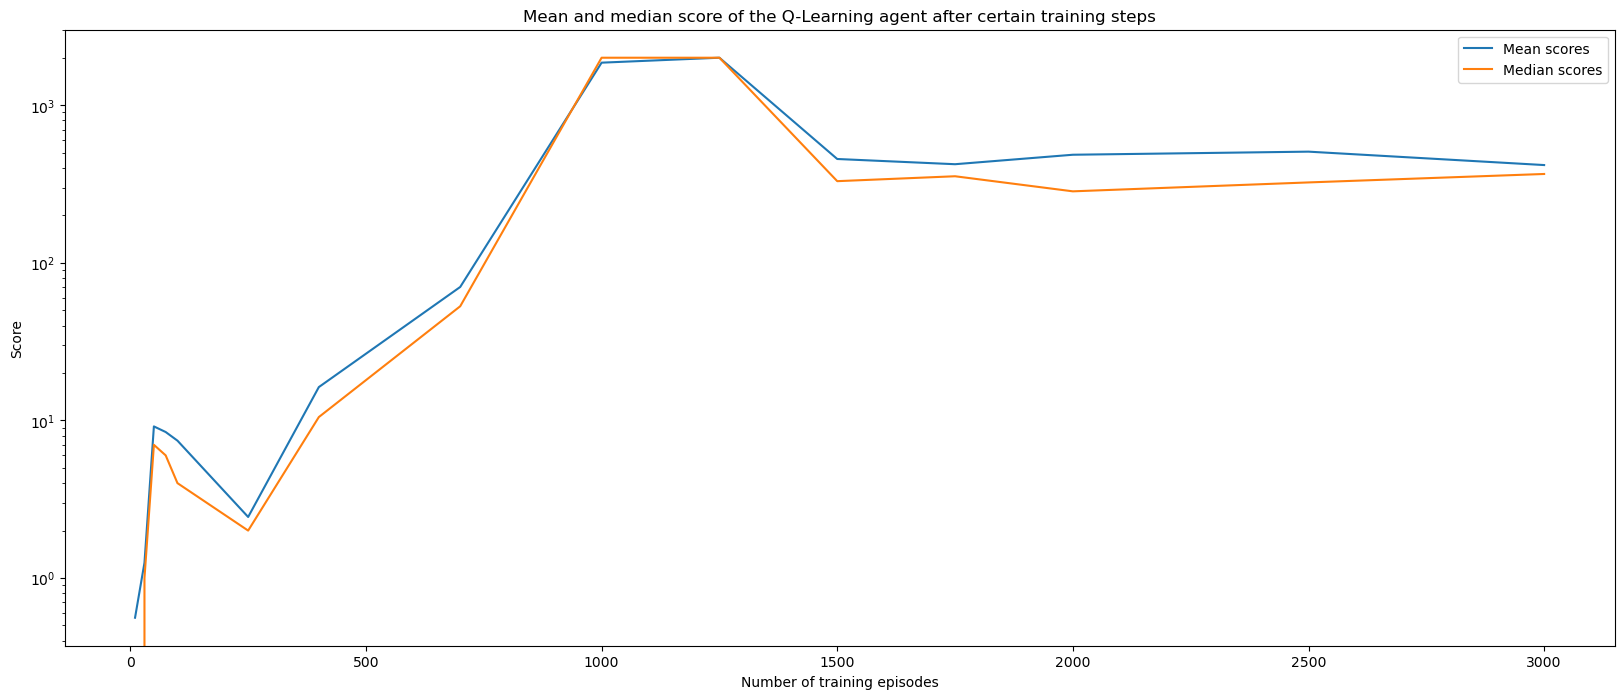

In [13]:
plt.plot(episodes_array, mean_scores, label="Mean scores")
plt.plot(episodes_array, median_scores, label="Median scores")

plt.title("Evolution of the scores of agents")

plt.xlabel("Number of training episodes")
plt.ylabel("Score")

plt.title("Mean and median score of the Q-Learning agent after certain training steps")

plt.yscale('log')

plt.legend()

plt.show()

We get convergence towards the optimal policy after 2000 episodes. To set a benchmark for the agent in order to test the convergence and performances, we will train a model for 5000 episodes to allow a certain margin.

Notice how the performance drops before going up again. We suspect that this is due to the learning rate or step size $\alpha$ that might be too big. That's why we introduce the parameter `i_lim` that indicated the training episode at which we start the decrease of the step size. We will try to optimize this parameter down below.

## Convergence rate and impact of parameters

In this section, we will perform parameter sweeps to see how each parameter impacts the performance of the agent.

To do so, we will vary one parameter while keeping all the others constant. We train train and agent for 3000 episodes and make it play 20 games for each parameter value. We then plot the evolution of the agent's score with respect to the studied parameter.

### Impact of $\alpha$

In [14]:
alpha_range = [0.01, 0.05, 0.1, 0.2, 0.5]
epsilon = 0.1
gamma = 0.9
i_lim = 3000

n_episodes = 3000

n_plays = 20

scores_list = []

for alpha in tqdm(alpha_range):
    average_score = 0
    
    for _ in range(n_plays):
        q_learning = Q_learning_flappy_bird(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)
        
        q_learning = q_learning.train(n_episodes=n_episodes,
                                    alpha=alpha,
                                    epsilon=epsilon,
                                    gamma=gamma,
                                    show_episodes=False,
                                    i_lim=i_lim
                                   )
        

        q_learning = q_learning.play(False)
        average_score += q_learning.score_play / n_plays
        
    scores_list.append(average_score)
        

100%|██████████████████████████████████████████████████████████████████| 5/5 [05:06<00:00, 61.25s/it]


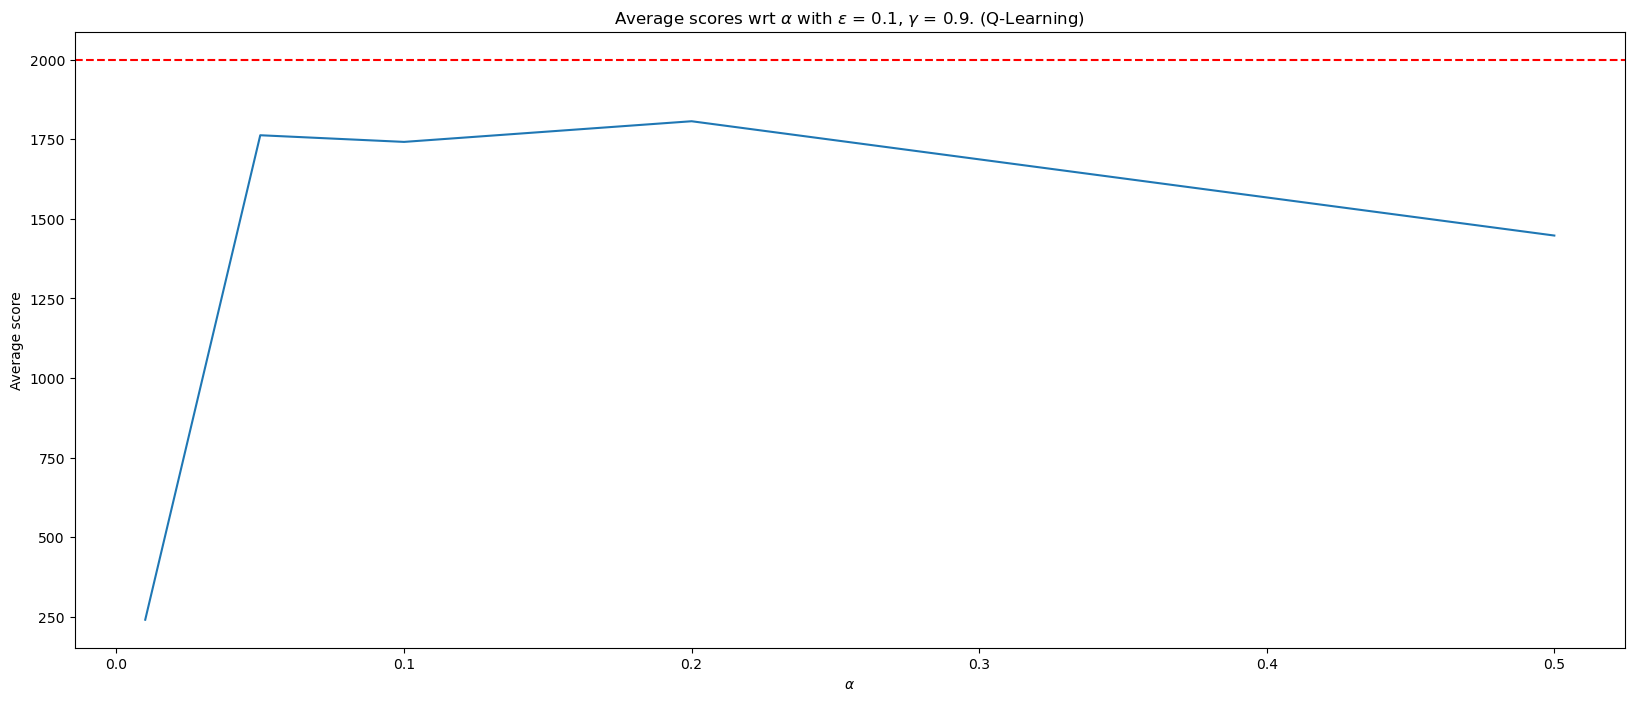

In [15]:
plt.plot(alpha_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel(r"$\alpha$")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt $\alpha$ with $\epsilon$ = {epsilon}, $\gamma$ = {gamma}. (Q-Learning)")

plt.show()

We notice that for very low values of $\alpha$, we get a very poor performance, and that for very high values of $\alpha$, the score decreases. 

$\alpha$ represents the step size or learning rate of the agent. Therefore, when the $\alpha$ is very low, the agent learns slowly and doesn't have time to reach the optimal policy. Whereas when $\alpha$ is very large, the agent has trouble to converge when it gets closer to the optimal policy. Therefore, the optimal $\alpha$ sits in between.

### Impact of $\epsilon$

In [16]:
alpha = 0.1
epsilon_range = [0.01, 0.05, 0.1, 0.2, 0.5]
gamma = 0.9
i_lim = 2000

n_episodes = 3000

n_plays = 10

scores_list = []

for epsilon in tqdm(epsilon_range):
    average_score = 0
    
    for _ in range(n_plays):
        q_learning = Q_learning_flappy_bird(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)
        
        q_learning = q_learning.train(n_episodes=n_episodes,
                                    alpha=alpha,
                                    epsilon=epsilon,
                                    gamma=gamma,
                                    show_episodes=False,
                                    i_lim=i_lim
                                   )
        

        q_learning = q_learning.play(False)
        average_score += q_learning.score_play / n_plays
        
    scores_list.append(average_score)

100%|██████████████████████████████████████████████████████████████████| 5/5 [07:07<00:00, 85.56s/it]


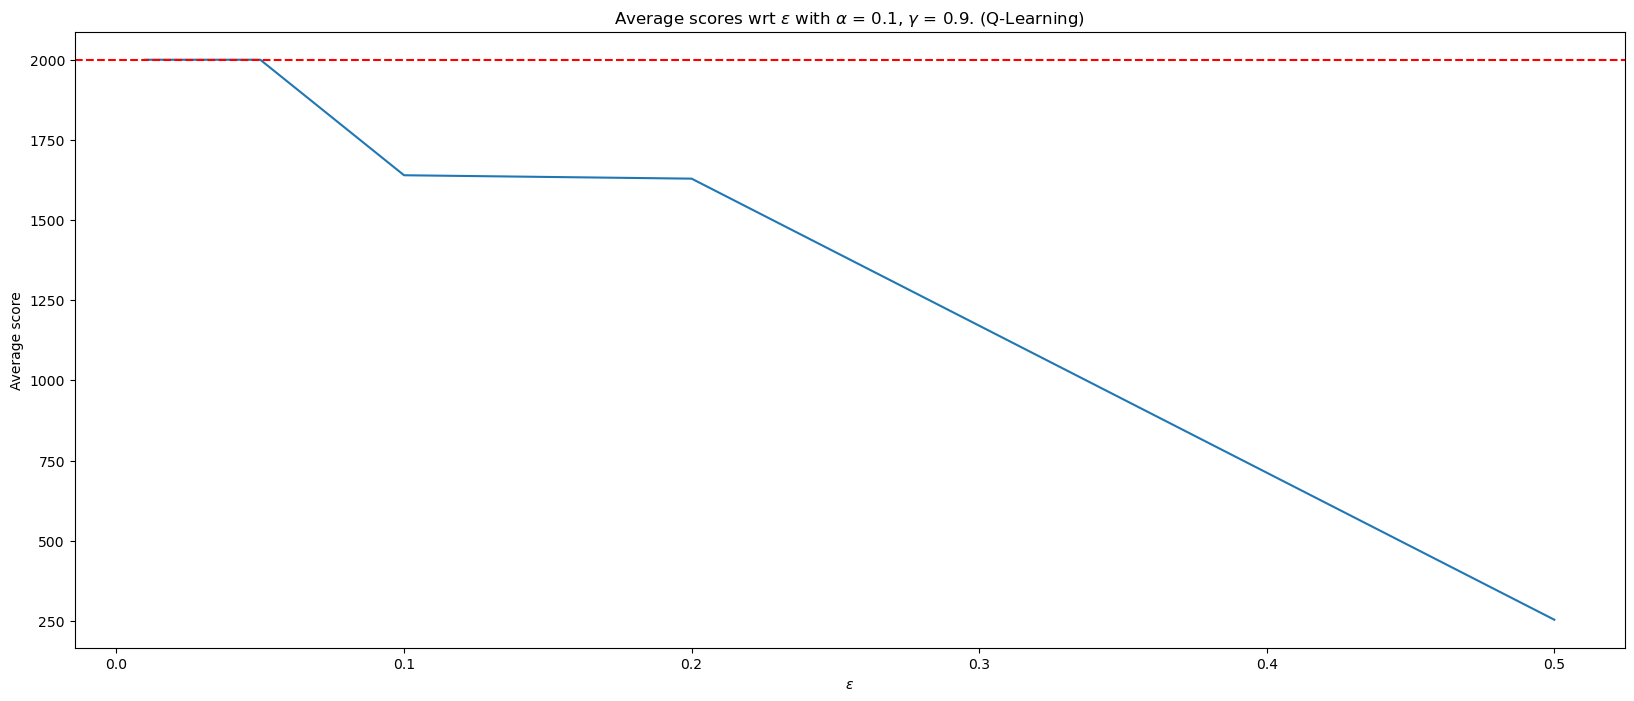

In [17]:
plt.plot(epsilon_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel(r"$\epsilon$")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt $\epsilon$ with $\alpha$ = {alpha}, $\gamma$ = {gamma}. (Q-Learning)")

plt.show()

We notice that for very low values of $\epsilon$, the performance is optimal as it constantly reaches 2000. However, as we increase $\epsilon$, the agent does too much exploration and very little exploitation, therfore it doesn't converge in due time. We also note that Q-Learning is an algorithm that notoriously doesn't do much exploration (cf. the Cliff Walking problem we saw in the Lab Session), therefore it isn't really impacted by how low the $\epsilon$ is.

### Impact of i_lim

i_lim is the episode number after which we start decreasing the step size $\alpha$ hyperbolically to assure convergence.

In [18]:
alpha = 0.1
epsilon = 0.1
gamma = 0.9
i_lim_range = [1000, 1500, 2000, 2500, 3000]

n_episodes = 3000

n_plays = 20

scores_list = []

for i_lim in tqdm(i_lim_range):
    average_score = 0
    
    for _ in range(n_plays):
        q_learning = Q_learning_flappy_bird(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)
        
        q_learning = q_learning.train(n_episodes=n_episodes,
                                    alpha=alpha,
                                    epsilon=epsilon,
                                    gamma=gamma,
                                    show_episodes=False,
                                    i_lim=i_lim
                                   )
        

        q_learning = q_learning.play(False)
        average_score += q_learning.score_play / n_plays
        
    scores_list.append(average_score)

100%|██████████████████████████████████████████████████████████████████| 5/5 [05:35<00:00, 67.09s/it]


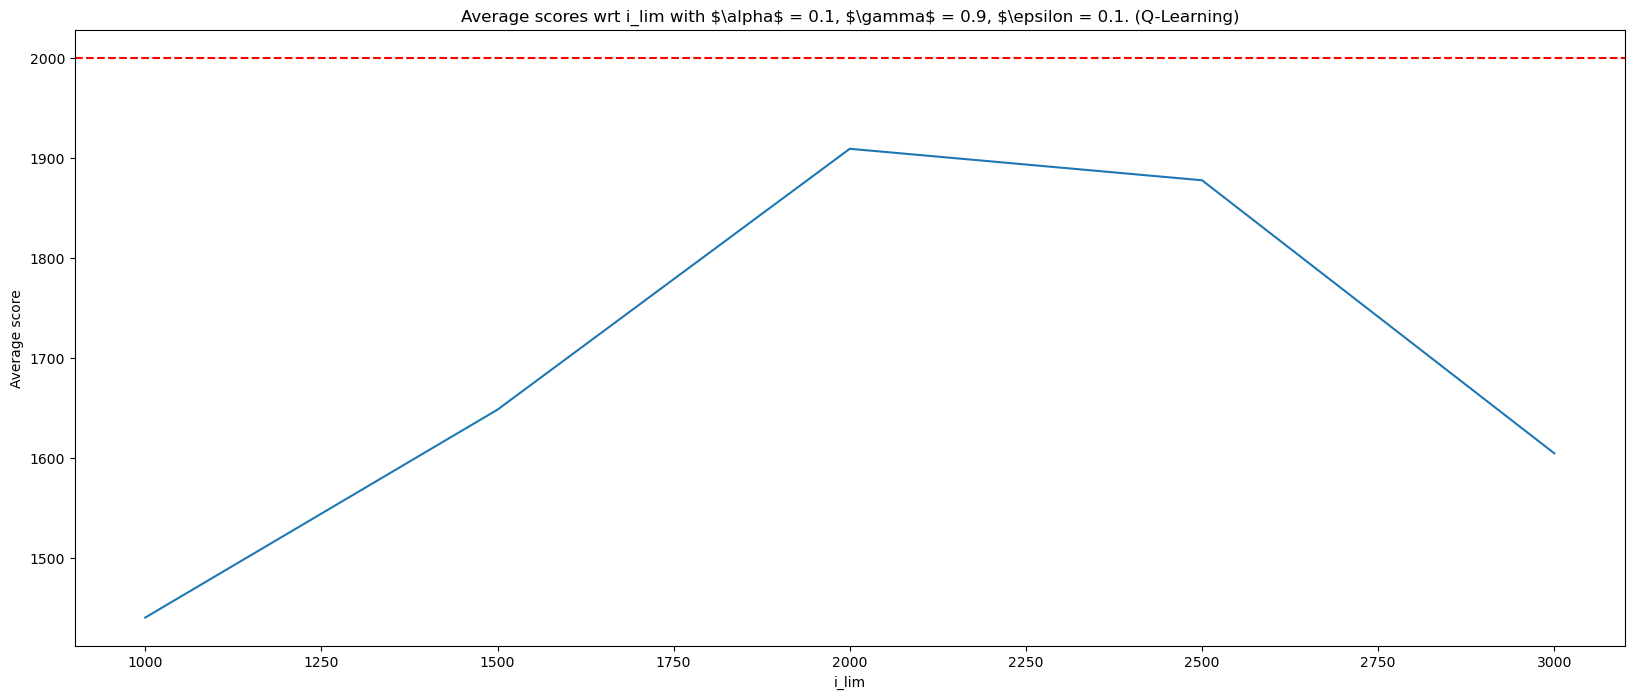

In [19]:
plt.plot(i_lim_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel("i_lim")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt i_lim with $\alpha$ = {alpha}, $\gamma$ = {gamma}, $\epsilon = {epsilon}. (Q-Learning)")

plt.show()

For low values of i_lim, we start decreasing the step size very early on, therefore we find ourselves in the case of a low $\alpha$. In the other case of high i_lim, since we train the agent for 3000 episodes, there is no decrease in step size, which hampers learning when we get closer to the optimum.

### Hyperparameter grid search

We perform a gird search on the space of hyperparameters. We will try all the different combinations of the parameters that we give it. We then train `n_trains` different agents that we make play `n_plays` times each. We then average their scores on each episode to obtain the plots of the evolution of the score.

The following function returns the list of mean and median scores of the Q Learning agent for a certain combination of parameters : $\alpha$, $\epsilon$, $\gamma$, $i_{lim}$.

In [20]:
def examine_parameter_combination_Q_learning(alpha, epsilon, gamma, i_lim, n_plays=20):
    height = 15
    width = 20
    pipe_gap = 4

    env = gym.make('TextFlappyBird-v0', 
                   height = height, 
                   width = width, 
                   pipe_gap = pipe_gap)

    q_learning = Q_learning_flappy_bird(env=env, 
                                      width = width, 
                                      height = height, 
                                      pipe_gap = pipe_gap)

    start_n_episodes = 10
    
    episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
    episodes_increments = [episodes_array[0]] + list(np.diff(episodes_array))


    median_scores = []
    mean_scores = []

    for i, n_episodes in enumerate(episodes_increments):
        train_model = q_learning.train(n_episodes=n_episodes,
                                          alpha=alpha,
                                          epsilon=epsilon,
                                          gamma=gamma,
                                          i_lim=i_lim,
                                          show_episodes=False)
        
        scores = []
        for _ in range(n_plays):
            model = train_model.play(False)
            scores.append(model.score_play)


        median_scores.append(np.median(scores))
        mean_scores.append(np.mean(scores))
    
    return median_scores, mean_scores

The following function returns the mean and median scores evolution with respect to the training episodes across all combinations of the arrays of hyperparameters.

In [21]:
def hyperparameter_tuning_Q_learning(alpha_range, epsilon_range, gamma_range, i_max_range, n_trains=10, n_plays=20):
    if type(alpha_range) == int or type(alpha_range) == float:
        alpha_range = [alpha_range]
    if type(epsilon_range) == int or type(epsilon_range) == float:
        epsilon_range = [epsilon_range]
    if type(gamma_range) == int or type(gamma_range) == float:
        gamma_range = [gamma_range]
    if type(i_max_range) == int or type(i_max_range) == float:
        i_max_range = [i_max_range]
    
    
    param_combinations = list(product(alpha_range, epsilon_range, gamma_range, i_max_range))
    
    result_dict = {'combinations' : [],
                   'alpha' : [],
                   'epsilon' : [],
                   'gamma' : [],
                   'i_max' : [],
                   'mean_score' : [],
                   'median_score' : [],
                   }
    
    for alpha, epsilon, gamma, i_max in tqdm(param_combinations, disable=False):
        
        #print(alpha, epsilon, gamma, i_max)
        
        mean_score_array_comb = []
        median_score_array_comb = []
        
        for _ in range(n_trains):
            median_scores_comb, mean_scores_comb = examine_parameter_combination_Q_learning(alpha, 
                                                                                            epsilon, 
                                                                                            gamma, 
                                                                                            i_max,
                                                                                            n_plays=n_plays,
                                                                                            )
            mean_score_array_comb.append(mean_scores_comb)
            median_score_array_comb.append(median_scores_comb)
        
        mean_score_array_comb = np.mean(np.array(mean_score_array_comb), axis=0)
        median_score_array_comb = np.mean(np.array(median_score_array_comb), axis=0)
        
        result_dict['combinations'].append((alpha, epsilon, gamma, i_max))
        result_dict['alpha'].append(alpha)
        result_dict['epsilon'].append(epsilon)
        result_dict['gamma'].append(gamma)
        result_dict['i_max'].append(i_max)
        result_dict['mean_score'].append(mean_score_array_comb)
        result_dict['median_score'].append(median_score_array_comb)
    
    return result_dict
    

We perform the gird search on the following parameters :
- $\alpha \in [0.05, 0.1, 0.2]$
- $\epsilon \in [0.05, 0.1]$
- $\gamma \in [0.9, 1]$
- $i_{lim} \in [1500, 2000, 2500]$

In [ ]:
alpha_range = [0.05, 0.1, 0.2]
epsilon_range = [0.05, 0.1]
gamma_range = [0.9, 1]
i_max_range = [1500, 2000, 2500]

n_trains = 10
n_plays = 20

result_dict = hyperparameter_tuning_Q_learning(alpha_range, 
                                                epsilon_range, 
                                                gamma_range, 
                                                i_max_range, 
                                                n_trains = n_trains, 
                                                n_plays = n_plays)


 75%|█████████████████████████████████████████████▊               | 27/36 [1:07:45<26:21, 175.75s/it]

We get the following `DataFrame`as a result.

In [ ]:
Q_result_df = pd.DataFrame(result_dict)

# We save the DataFrame
Q_result_df.to_csv("Hyperparameter results Q-Learning")

Q_result_df.head()

We display the best score curves

In [ ]:
episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

for index, row in Q_result_df.iterrows():
    alpha = row['alpha']
    epsilon = row['epsilon']
    gamma = row['gamma']
    i_max = row['i_max']
    
    median_score = row['median_score']
    mean_score = row['mean_score']
    
    instances_max = np.sum(np.array(mean_score) == 2000)
    
    # We only select the curves that reach 2000 more than twice
    if instances_max > 3 :
    
        label = fr"$\alpha$={alpha}, $\epsilon$={epsilon}, $\gamma$={gamma}, i_max={i_max}"

        plt.plot(episodes_array, mean_score, label=label)

plt.xlabel("Training episodes")
plt.ylabel("Score")

plt.title("Mean score convergence wrt. the number of training episodes for different hyperparameter combinations")

plt.legend()

plt.show()

## State-action function

We obtain the state-action function by plotting the Q-matrix as a heatmap. We train an agent for 10'000 episodes and observe how the matrix looks.

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

In [ ]:
alpha = 0.2
epsilon = 0.01
gamma = .8

benchmark_episodes = 10000

benchmark_agent = Q_learning_flappy_bird(env=env, 
                                            width = width, 
                                            height = height, 
                                            pipe_gap = pipe_gap)
    
benchmark_agent = benchmark_agent.train(n_episodes=benchmark_episodes,
                                        alpha=alpha,
                                        epsilon=epsilon,
                                        gamma=gamma,
                                        show_episodes=False)

In [ ]:
benchmark_policy = np.argmax(benchmark_agent.Q, axis=-1)
benchmark_policy = benchmark_policy[::-1, ::-1]

We apply a 4x4 convolution to apply the average over a square of side 4 in order to smoothen the matrix.

In [ ]:
window = np.ones((4, 4))
window = window / window.size
benchmark_policy_average = convolve2d(benchmark_policy, window, mode='valid')

In [ ]:
extent = [20 , 0, 15 , -15]

plt.imshow(benchmark_policy_average.T, cmap='hot', extent=extent)

plt.colorbar()

plt.xlabel("Horizontal distance to center of gap")
plt.ylabel("Vertical distance to center of gap")

plt.title("State-value heat map for Q-Learning")

plt.show()

## Method 2 : Expected SARSA

This implementation is based on the eponymous section 6.6 from __Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.__

We structure of the following class is very similar to that of the Q Learning one. Indeed, the only difference is the update formula of the Q matrix, as is outlined in the reference book cited above. For ease of notation, even though the following class is named `SARSA_flappy_bird`, it is indeed an implementation of the Expected SARSA algorithm.

In [ ]:
class SARSA_flappy_bird():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        self.max_score = 2000
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        
        self.Q = np.random.rand(n_x_states, n_y_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :] = 0
        
        self.train_iteration = -1
        
        self.score_history = []
        self.death_causes = []
        self.reward_history = []
        
        self.accuracy_history = []
        
        self.death_cause_play = None
        self.score_play = None
        self.reward_play = None
    
    
    def _distance_to_state(self, x, y):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        return state_x, state_y
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind
    
    def _step_size(self, alpha, i, i_lim=1000):
        """
        Defines the step size choosing policy to assure convergence.
        """
        if (i > i_lim):
            return alpha / ((i - i_lim) ** 1)
        else:
            return alpha
    
    
    def _epsilon_decay(self, epsilon, i, i_lim=1000):
        if i <= i_lim:
            return epsilon
        return epsilon / ((i - i_lim) ** 1)
    
    
    def _epsilon_greedy(self, epsilon, x, y):
        """
        Defines the epsilon-greedy policy of training.
        """
        random_number = np.random.random()
        if random_number < epsilon:
            action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
        else:
            action = self._argmax(self.Q[x, y, :])
        
        return action
    
    def _render_game(self, i, top_score, sleep_time):
        """
        Renders the game with a certain sleep time (1/FPS)
        """
        os.system("clear")
        
        if i:
            print(f"Episode : {i+1}/{n_episodes}")
            
        print("Top score :", top_score)
        
        sys.stdout.write(self.env.render())
        
        if sleep_time:
            time.sleep(sleep_time) # FPS

        clear_output(wait=True)
    
    
    def _evaluate_distance_to_benchmark(self, Q_benchmark):
        benchmark_policy = np.argmax(Q_benchmark, axis=-1)
        current_policy = np.argmax(self.Q, axis=-1)
        
        accuracy = np.sum(benchmark_policy == current_policy)
        accuracy = accuracy / benchmark_policy.size
        
        return accuracy
    

    
    def train(self, n_episodes, alpha, epsilon, gamma, i_lim=1000, Q_benchmark=None, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            
            self.train_iteration += 1
            
            obs = self.env.reset()
            x, y = obs[0]
            x, y = self._distance_to_state(x, y)
            
            action = self._epsilon_greedy(epsilon, x, y)
            
            cumulative_reward = 0
            
            while True:

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                
                action_ = self._epsilon_greedy(epsilon, x_, y_)
                
                
                # Treatment relative to the score, reward, terminal conditions
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    else:
                        self.death_causes.append("Floor")
                
                # If we reach the Max Score
                if score == self.max_score:
                    done = True
                    self.death_causes.append("Max score")
                        
                # If we manage to go through a gap, we get a reward of 10
                elif x==0 and not done:
                    reward = 1
                
                cumulative_reward += reward
                
                
                # Update the Q according to the Q-learning update equation
                step_size = self._step_size(alpha, self.train_iteration, i_lim=i_lim)
                
                current_q = self.Q[x_, y_, :]
                max_q = np.max(current_q)
                n_actions_max_q = np.sum(max_q == current_q)
                num_actions = 2
                
                q_update = 0
                
                for i in range(num_actions): 
                    if current_q[i] == max_q:
                        q_update += current_q[i] * (((1-epsilon) / n_actions_max_q) + (epsilon/num_actions))
                    else:
                        q_update += current_q[i] * (epsilon / num_actions)

                
                self.Q[x, y, action] += step_size * (reward + gamma * q_update - self.Q[x, y, action])
                
                # Update x and y
                x, y = x_, y_
                action = action_
                
                # Calculate accuracy with respect to benchmark
                if Q_benchmark is not None:
                    self.accuracy_history.append(self._evaluate_distance_to_benchmark(Q_benchmark))
                
                # Render the game
                if show_episodes:
                    self._render_game(i, top_score, 0)

                # If player is dead break
                if done:
                    self.Q[x, y, action] += step_size * (reward - self.Q[x, y, action])
                    break
            
            self.score_history.append(score)
            self.reward_history.append(cumulative_reward)

        self.env.close()
        
        return self
    
    
    def plot_training_rewards(self):
        plt.plot(self.reward_history)
        plt.xlabel("Training episodes")
        plt.ylabel("Rewards")
        
        plt.show()
    
    
    def play(self, display=True, sleep_time=0.1):
        obs = self.env.reset()
        x, y = obs[0]
        x, y = self._distance_to_state(x, y)
        self.reward_play = 0
        
        top_score = float("-inf")

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            
            score = info['score']
            if score > top_score:
                top_score = score

            
            if not done and x == 0:
                reward = 10
            elif done:
                reward = -100
            self.reward_play += reward
            
            if done and (score != self.max_score):
                if x == 0:
                    self.death_cause_play = "Collision"
                else:
                    self.death_cause_play = "Floor"
            
            
            #print(self.score_play)
            # Render the game
            if display:
                self._render_game(None, top_score, sleep_time)
            
            # Early breaking if the agent performs well and doesn't stop
            if score == self.max_score:
                done = True
                self.death_cause_play = "Max Score"

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        self.env.close()
        
        return self

### Do the rewards converge ?

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

In [ ]:
alpha = 0.1
epsilon = .1
gamma = .9

train_episodes = 5000
n_agents = 10

rewards_array = []



for i in tqdm(range(n_agents)):
    sarsa = SARSA_flappy_bird(env=env, 
                              width = width, 
                              height = height, 
                              pipe_gap = pipe_gap)
    
    sarsa = sarsa.train(n_episodes=train_episodes,
                      alpha=alpha,
                      epsilon=epsilon,
                      gamma=gamma,
                      show_episodes=False,
                      i_lim = 3000)
    
    rewards_array.append(sarsa.reward_history)

In [ ]:
rewards_array = np.array(rewards_array)
mean_rewards_per_step = np.mean(rewards_array, axis=0)

window_size = 50
moving_average_scores = np.convolve(mean_rewards_per_step, np.ones(window_size), 'valid') / window_size

plt.plot(mean_rewards_per_step, label="Cumulative rewards")
plt.plot(moving_average_scores, label="Moving average")

plt.xlabel("Training Episodes")
plt.ylabel("Mean rewards across agents")

plt.title("Training rewards evolution of the Expected SARSA Agent")

plt.legend()

plt.show()

The training rewards demonstrate a nice and steady convergence as we increase the training episodes. The values of the average rewards stagnates at around $10$.

The training rewards demonstrate a nice and steady convergence as we increase the training episodes.

### Examining the score with respect to the number of training episodes :

In this section, we investigate on the relationship between the number of training episodes and the median/mean score reached by the agent.

To do this, we first start by selecting certain episodes that we want to perform the check on. We then initialize an agent that we train for the difference between each episode step (eg. if we already trained the agent for 200 episodes and the next episode step is 300, we will train the agent for the remaining 100 episodes). At each step, we make the agent play 100 games, and then take the mean and median score of those 100 plays.

This allows us to plot the average and median score of the agent at each training episode step.

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

sarsa = SARSA_flappy_bird(env=env, 
                          width = width, 
                          height = height, 
                          pipe_gap = pipe_gap)

To do this, we first start by selecting certain episodes that we want to perform the check on. We then initialize an agent that we train for the difference between each episode step (eg. if we already trained the agent for 200 episodes and the next episode step is 300, we will train the agent for the remaining 100 episodes). At each step, we make the agent play 100 games, and then take the mean and median score of those 100 plays.

This allows us to plot the average and median score of the agent at each training episode step.

In [ ]:
alpha = 0.1
epsilon = 0.1
gamma = .9

start_n_episodes = 10
end_n_episodes = 3000
n_steps = 40

episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
episodes_increments = [start_n_episodes] + list(np.diff(episodes_array))

raw_results = []
median_scores = []
mean_scores = []
dict_scores = {}

for i, n_episodes in enumerate(episodes_increments):
    train_model = sarsa.train(n_episodes=n_episodes,
                                  alpha=alpha,
                                  epsilon=epsilon,
                                  gamma=gamma,
                                  i_lim=1500,
                                  show_episodes=False)

    n_plays = 100
    print(f"Training with {episodes_array[i]} episodes :")
    scores = []
    for _ in tqdm(range(n_plays)):
        model = train_model.play(False, sleep_time=0)
        scores.append(model.score_play)
        raw_results.append(model.score_play)
    
    dict_scores[episodes_array[i]] = scores
        
    median_scores.append(np.median(scores))
    mean_scores.append(np.mean(scores))

In [ ]:
plt.plot(episodes_array, mean_scores, label="Mean scores")
plt.plot(episodes_array, median_scores, label="Median scores")

plt.title("Evolution of the scores of agents")

plt.xlabel("Number of training episodes")
plt.ylabel("Score")

plt.yscale('log')

plt.legend()

plt.show()

We get convergence towards the optimal policy after 2000 episodes.

### Hyperparameter sweep

### Impact of $\alpha$

In [ ]:
alpha_range = [0.01, 0.05, 0.1, 0.2, 0.5]
epsilon = 0.1
gamma = 0.9
i_lim = 3000

n_episodes = 3000

n_plays = 20

scores_list = []

for alpha in tqdm(alpha_range):
    average_score = 0
    
    for _ in range(n_plays):
        sarsa = SARSA_flappy_bird(env=env, 
                              width = width, 
                              height = height, 
                              pipe_gap = pipe_gap)
        
        sarsa = sarsa.train(n_episodes=n_episodes,
                            alpha=alpha,
                            epsilon=epsilon,
                            gamma=gamma,
                            show_episodes=False,
                            i_lim=i_lim
                           )
        

        sarsa = sarsa.play(False)
        average_score += sarsa.score_play / n_plays
        
    scores_list.append(average_score)
        

In [ ]:
plt.plot(alpha_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel(r"$\alpha$")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt $\alpha$ with $\epsilon$ = {epsilon}, $\gamma$ = {gamma}.")

plt.show()

We notice that for very low values of $\alpha$, we get a very poor performance, and that for very high values of $\alpha$, the score decreases. 

$\alpha$ represents the step size or learning rate of the agent. Therefore, when the $\alpha$ is very low, the agent learns slowly and doesn't have time to reach the optimal policy. Whereas when $\alpha$ is very large, the agent has trouble to converge when it gets closer to the optimal policy. Therefore, the optimal $\alpha$ sits in between.

### Impact of $\epsilon$

In [ ]:
alpha = 0.1
epsilon_range = [0.01, 0.05, 0.1, 0.2, 0.5]
gamma = 0.9
i_lim = 2000

n_episodes = 3000

n_plays = 10

scores_list = []

for epsilon in tqdm(epsilon_range):
    average_score = 0
    
    for _ in range(n_plays):
        sarsa = SARSA_flappy_bird(env=env, 
                              width = width, 
                              height = height, 
                              pipe_gap = pipe_gap)
        
        sarsa = sarsa.train(n_episodes=n_episodes,
                            alpha=alpha,
                            epsilon=epsilon,
                            gamma=gamma,
                            show_episodes=False,
                            i_lim=i_lim
                           )
        

        sarsa = sarsa.play(False)
        average_score += sarsa.score_play / n_plays
        
    scores_list.append(average_score)

In [ ]:
plt.plot(epsilon_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel(r"$\epsilon$")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt $\epsilon$ with $\alpha$ = {alpha}, $\gamma$ = {gamma}.")

plt.show()

We notice that for very low values of $\epsilon$, the performance is optimal as it constantly reaches 2000. However, as we increase $\epsilon$, the agent does too much exploration and very little exploitation, therfore it doesn't converge in due time. We also note that Q-Learning is an algorithm that notoriously doesn't do much exploration (cf. the Cliff Walking problem we saw in the Lab Session), therefore it isn't really impacted by how low the $\epsilon$ is.

### Impact of i_lim

In [ ]:
alpha = 0.1
epsilon = 0.1
gamma = 0.9
i_lim_range = [1000, 1500, 2000, 2500, 3000]

n_episodes = 3000

n_plays = 20

scores_list = []

for i_lim in tqdm(i_lim_range):
    average_score = 0
    
    for _ in range(n_plays):
        sarsa = SARSA_flappy_bird(env=env, 
                              width = width, 
                              height = height, 
                              pipe_gap = pipe_gap)
        
        sarsa = sarsa.train(n_episodes=n_episodes,
                            alpha=alpha,
                            epsilon=epsilon,
                            gamma=gamma,
                            show_episodes=False,
                            i_lim=i_lim
                           )
        

        sarsa = sarsa.play(False)
        average_score += sarsa.score_play / n_plays
        
    scores_list.append(average_score)

In [ ]:
plt.plot(i_lim_range, scores_list)
plt.axhline(y = 2000, color = 'r', linestyle = '--')

plt.xlabel("i_lim")
plt.ylabel("Average score")

plt.title(fr"Average scores wrt i_lim with $\alpha$ = {alpha}, $\gamma$ = {gamma}, $\epsilon = {epsilon}.")

plt.show()

### Hyperparameter grid search

We will now sweep across the whole space of hyperparameters, ie. we will move all the hyperparameters at once to find the best combination. We do this using a "grid search" paradigm.

In [ ]:
def examine_parameter_combination_SARSA(alpha, epsilon, gamma, i_lim, n_plays=20):
    height = 15
    width = 20
    pipe_gap = 4

    env = gym.make('TextFlappyBird-v0', 
                   height = height, 
                   width = width, 
                   pipe_gap = pipe_gap)

    sarsa = SARSA_flappy_bird(env=env, 
                              width = width, 
                              height = height, 
                              pipe_gap = pipe_gap)

    start_n_episodes = 10
    end_n_episodes = 3000
    n_steps = 40

    #episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
    episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
    episodes_increments = [episodes_array[0]] + list(np.diff(episodes_array))


    median_scores = []
    mean_scores = []

    for i, n_episodes in tqdm(enumerate(episodes_increments), disable=True):
        train_model = sarsa.train(n_episodes=n_episodes,
                                  alpha=alpha,
                                  epsilon=epsilon,
                                  gamma=gamma,
                                  i_lim=i_lim,
                                  show_episodes=False)
        
        scores = []
        for _ in range(n_plays):
            model = train_model.play(False)
            scores.append(model.score_play)


        median_scores.append(np.median(scores))
        mean_scores.append(np.mean(scores))
    
    return median_scores, mean_scores

In [ ]:
def hyperparameter_tuning_SARSA(alpha_range, epsilon_range, gamma_range, i_max_range, n_trains=10, n_plays=20):
    if type(alpha_range) == int or type(alpha_range) == float:
        alpha_range = [alpha_range]
    if type(epsilon_range) == int or type(epsilon_range) == float:
        epsilon_range = [epsilon_range]
    if type(gamma_range) == int or type(gamma_range) == float:
        gamma_range = [gamma_range]
    if type(i_max_range) == int or type(i_max_range) == float:
        i_max_range = [i_max_range]
    
    
    param_combinations = list(product(alpha_range, epsilon_range, gamma_range, i_max_range))
    
    result_dict = {'combinations' : [],
                   'alpha' : [],
                   'epsilon' : [],
                   'gamma' : [],
                   'i_max' : [],
                   'mean_score' : [],
                   'median_score' : [],
                   }
    
    for alpha, epsilon, gamma, i_max in tqdm(param_combinations, disable=False):
        
        #print(alpha, epsilon, gamma, i_max)
        
        mean_score_array_comb = []
        median_score_array_comb = []
        
        for _ in range(n_trains):
            median_scores_comb, mean_scores_comb = examine_parameter_combination_SARSA(alpha, 
                                                                                        epsilon, 
                                                                                        gamma, 
                                                                                        i_max,
                                                                                        n_plays=n_plays,
                                                                                        )
            mean_score_array_comb.append(mean_scores_comb)
            median_score_array_comb.append(median_scores_comb)
        
        mean_score_array_comb = np.mean(np.array(mean_score_array_comb), axis=0)
        median_score_array_comb = np.mean(np.array(median_score_array_comb), axis=0)
        
        result_dict['combinations'].append((alpha, epsilon, gamma, i_max))
        result_dict['alpha'].append(alpha)
        result_dict['epsilon'].append(epsilon)
        result_dict['gamma'].append(gamma)
        result_dict['i_max'].append(i_max)
        result_dict['mean_score'].append(mean_score_array_comb)
        result_dict['median_score'].append(median_score_array_comb)
    
    return result_dict
    

We perform the gird search on the following parameters :
- $\alpha \in [0.05, 0.1, 0.2]$
- $\epsilon \in [0.05, 0.1]$
- $\gamma \in [0.9, 1]$
- $i_{lim} \in [1500, 2000, 2500]$

In [ ]:
alpha_range = [0.05, 0.1, 0.2]
epsilon_range = [0.05, 0.1]
gamma_range = [0.9, 1]
i_max_range = [1500, 2000, 2500]

n_trains = 10
n_plays = 20

result_dict = hyperparameter_tuning_SARSA(alpha_range, 
                                        epsilon_range, 
                                        gamma_range, 
                                        i_max_range, 
                                        n_trains = n_trains, 
                                        n_plays = n_plays)


In [ ]:
SARSA_result_df = pd.DataFrame(result_dict)

SARSA_result_df.to_csv("Hyperparameter results Expected SARSA")

SARSA_result_df.head()

In [ ]:
episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

for index, row in SARSA_result_df.iterrows():
    alpha = row['alpha']
    epsilon = row['epsilon']
    gamma = row['gamma']
    i_max = row['i_max']
    
    median_score = row['median_score']
    mean_score = row['mean_score']
    
    instances_max = np.sum(np.array(mean_score) > 1800)
    
    # We only select the curves that reach 1850 at least 4 times
    
    if instances_max > 1 :
    
        label = fr"$\alpha$={alpha}, $\epsilon$={epsilon}, $\gamma$={gamma}, i_max={i_max}"

        plt.plot(episodes_array, mean_score, label=label)

plt.xlabel("Training episodes")
plt.ylabel("Score")

plt.title("Score convergence of Expected SARSA wrt. the number of training episodes for different hyperparameter combinations")

plt.legend()

plt.show()

### State-value

First, we need to train a benchmark agent. As said before, we will train it on 5000 episodes.

To compare the different models, we will calculate the distance between the Q-values of the models and the Q-values of the benchmark.

In [ ]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

In [ ]:
alpha = 0.2
epsilon = 0.05
gamma = 1.

benchmark_episodes = 10000

benchmark_agent = SARSA_flappy_bird(env=env, 
                                    width = width, 
                                    height = height, 
                                    pipe_gap = pipe_gap)
    
benchmark_agent = benchmark_agent.train(n_episodes=benchmark_episodes,
                                        alpha=alpha,
                                        epsilon=epsilon,
                                        gamma=gamma,
                                        show_episodes=False)

In [ ]:
benchmark_policy = np.argmax(benchmark_agent.Q, axis=-1)
benchmark_policy = benchmark_policy[::-1, ::-1]

In [ ]:
window = np.ones((4, 4))
window = window / window.size
benchmark_policy_average = convolve2d(benchmark_policy, window, mode='valid')

In [ ]:
extent = [20 , 0, 15 , -15]

plt.imshow(benchmark_policy_average.T, cmap='hot', extent=extent)



plt.colorbar()

plt.xlabel("Horizontal distance to center of gap")
plt.ylabel("Vertical distance to center of gap")

plt.title("State-value heat map for Expected SARSA")

plt.show()

# Using the original Flappy Bird environment

In [ ]:
import flappy_bird_gym

In [ ]:
env = flappy_bird_gym.make("FlappyBird-v0")
obs = env.reset()

while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    #if np.random.random() < .05:
    #    action = 1
    #else:
    #    action = 0
    obs, reward, done, info = env.step(action)

    # Render the game
    os.system("clear")
    env.render()
    time.sleep(1/30) # FPS
    
    clear_output(wait=True)
    
    # If player is dead break
    if done:
        break

env.close()

In [ ]:
print("Observation returned by the environment :", obs)